## 分析A/B测试结果

## 目录
- [简介](#intro)
- [I - 概率](#probability)
- [II - A/B 测试](#ab_test)
- [III - 回归](#regression)


<a id='intro'></a>
### 简介

本项目关于电子商务网站运行的 A/B 测试的结果。目标是通过这个 notebook 来帮助公司弄清楚他们是否应该使用新的页面，保留旧的页面，或者应该将测试时间延长，之后再做出决定。

#### I - 概率


In [93]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` 现在，导入 `ab_data.csv` 数据，并将其存储在 `df` 中。

a. 导入数据集，并在这里查看前几行：

In [94]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. 使用下面的单元格来查找数据集中的行数。

In [95]:
# 数据集样本数和列数
df.shape[0]

294478

c. 数据集中独立用户的数量。

In [96]:
df['user_id'].nunique()

290584

d. 用户转化的比例。

In [97]:
df[df['converted'] == 1]['user_id'].nunique() / df['user_id'].nunique()

0.12104245244060237

e.  `new_page` 与 `treatment` 不一致的次数。

In [98]:
# 解法1
treatment = df.group == 'treatment'
new_page = df.landing_page == 'new_page'
mismatch = treatment != new_page
mismatch.sum()

3893

In [99]:
# 解法2
# 2.1.数据集new_page 与 treatment匹配的行数
df.query("group == 'treatment' and landing_page == 'new_page'").count()[0]

145311

In [100]:
# 2.2.数据集old_page 与 control匹配的行数
df.query("group == 'control' and landing_page == 'old_page'").count()[0]

145274

In [101]:
# 2.3.new_page 与 treatment 不一致的次数
df.shape[0] - df.query("group == 'treatment' and landing_page == 'new_page'").count()[0] - df.query("group == 'control' and landing_page == 'old_page'").count()[0]

3893

In [102]:
# 解法3.综合的解法
df.query('(group == "treatment" and landing_page != "new_page") or (group != "treatment" and landing_page == "new_page")').shape[0]

3893


f. 是否有任何行存在缺失值？

In [103]:
# 数据集具有缺失值的行数
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` 对于 **treatment** 不与 **new_page** 一致的行或 **control** 不与 **old_page** 一致的行，我们不能确定该行是否真正接收到了新的或旧的页面。
a. 现在，使用测试题的答案创建一个符合测试规格要求的新数据集。将新 dataframe 存储在 **df2** 中。

In [104]:
# 解法1
df2 = df[~mismatch].copy()

In [105]:
# 解法2
df2 = df.query('(group == "treatment" and landing_page == "new_page") or (group == "control" and landing_page == "old_page")')

In [106]:
# 解法3：分步获得
# 1.使用query函数获取treatment 与 new_page 一致的行，储存在df2_1数据集中
# df2_1 = df.query("group == 'treatment' and landing_page == 'new_page'")
# 2.使用query函数获取 control 与 old_page 一致的行，储存在df2_2数据集中
# df2_2 = df.query("group == 'control' and landing_page == 'old_page'")
# 3.合并df2_1和df_2_2数据集，储存在df2中
# df2 = df2_1.append(df2_2)
# 解法3：df2 = df[~mismatch].copy()

In [107]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` 使用 **df2** 与下面的单元格来回答问题。

a.  **df2** 中有多少唯一的 **user_id**?

In [108]:
df2['user_id'].nunique()

290584

b.  **df2** 中有一个重复的 **user_id** 。它是什么？ 

In [109]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. 这个重复的  **user_id** 的行信息是什么？

In [110]:
df2[df2.user_id.duplicated(keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. 删除 **一个** 含有重复的 **user_id** 的行， 但需要确保你的 dataframe 为 **df2**。

In [111]:
# df2.user_id.drop_duplicates(keep='last',inplace=True)
df2.drop_duplicates('user_id', 'first', inplace=True)

C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [112]:
print(df2.shape)

(290584, 5)


`4.` 在下面的单元格中，使用 **df2** 来回答问题。

a. 不管它们收到什么页面，单个用户的转化率是多少？


In [113]:
df2[df2['converted'] == 1].shape[0] / df2.shape[0]

0.11959708724499628

b. 假定一个用户处于 `control` 组中，他的转化率是多少？

In [114]:
control = df2[df2['group'] == 'control']

control[control['converted'] == 1].shape[0] / control.shape[0]

0.1203863045004612

c. 假定一个用户处于 `treatment` 组中，他的转化率是多少？


In [115]:
treatment = df2[df2['group'] == 'treatment']

treatment[treatment['converted'] == 1].shape[0] / treatment.shape[0]

0.11880806551510564

d. 一个用户收到新页面的概率是多少？


In [116]:
(df2.landing_page == "new_page").mean()

0.5000619442226688

e. 使用这个问题的前两部分的结果，给出建议：

**我认为没有足够的证据表明一个页面可以带来更多的变化，因为从转化率上来看，整体转化率、对照组转化率和实验组转化率没有很大的区别。**

<a id='ab_test'></a>
### II - A/B 测试

由于与每个事件相关的时间戳，可以在进行每次观察时连续运行假设检验。  

然而，问题的难点在于，一个页面被认为比另一页页面的效果好得多的时候你就要停止检验吗？还是需要在一定时间内持续发生？需要将检验运行多长时间来决定哪个页面比另一个页面更好？


`1.` 零假设和备择假设是什么？ 

$$H_0: p_{old} \geq p_{new}$$

$$H_1: p_{old} < p_{new}$$

`2.` 假定在零假设中，不管是新页面还是旧页面， $p_{new}$ and $p_{old}$ 都具有等于 **转化** 成功率的“真”成功率，也就是说，  $p_{new}$ 与 $p_{old}$ 是相等的。此外，假设它们都等于**ab_data.csv** 中的 **转化** 率，新旧页面都是如此。  <br><br>

每个页面的样本大小要与 **ab_data.csv** 中的页面大小相同。  <br><br>

执行两次页面之间 **转化** 差异的抽样分布，计算零假设中10000次迭代计算的估计值。  <br><br>


a. 在零假设中，$p_{new}$ 的 **convert rate（转化率）** 是多少？


In [56]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. 在零假设中， $p_{old}$  的 **convert rate（转化率）** 是多少？ <br><br>

In [57]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

c.  $n_{new}$ 是多少？

In [52]:
n_new = df2.query("landing_page == 'new_page'").count()[0]
n_new

145310

d.  $n_{old}$?是多少？

In [53]:
n_old = df2.query("landing_page == 'old_page'").count()[0]
n_old

145274

e. 在零假设中，使用 $p_{new}$ 转化率模拟 $n_{new}$ 交易，并将这些 $n_{new}$ 1's 与 0's 存储在 **new_page_converted** 中。(提示：可以使用  [numpy.random.choice](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.choice.html)。)

In [58]:
new_page_converted = np.random.choice([0,1],n_new, p=(1-p_new, p_new))

f. 在零假设中，使用 $p_{old}$ 转化率模拟 $n_{old}$ 交易，并将这些  $n_{old}$ 1's 与 0's 存储在 **old_page_converted** 中。

In [59]:
old_page_converted = np.random.choice([0,1],n_old, p=(1-p_old, p_old))

g. 在 (e) 与 (f)中找到 $p_{new}$ - $p_{old}$ 模拟值。

In [60]:
new_page_converted.mean() - old_page_converted.mean()

0.001670693259742187

h. 使用**a. 到 g. ** 中的计算方法来模拟 10,000个 $p_{new}$ - $p_{old}$ 值，并将这 10,000 个值存储在 **p_diffs** 中。

In [61]:
p_diffs = []

for _ in range(10000):
    new_page_converted = np.random.choice([0,1], n_new, p = [1-p_new, p_new])
    old_page_converted = np.random.choice([0,1], n_old, p = [1-p_old, p_old])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())
    

i. 绘制一个 **p_diffs** 直方图。
  直方图与我期望的一样，样本量足够大，呈正态分布，均值为0。

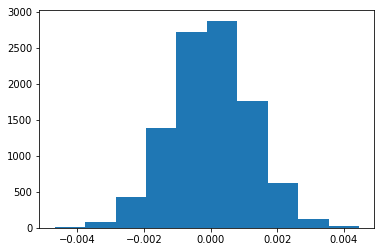

In [63]:
plt.hist(p_diffs);

j.  在**p_diffs**列表的数值中，有多大比例大于 **ab_data.csv** 中观察到的实际差值？

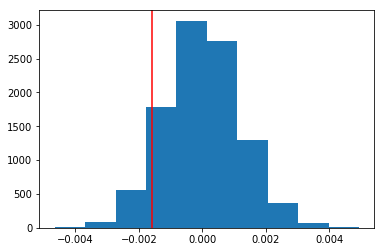

In [69]:
actual_diff = treatment[treatment['converted'] == 1].shape[0] / treatment.shape[0] - control[control['converted'] == 1].shape[0] / control.shape[0]

null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

plt.hist(null_vals);
plt.axvline(x=actual_diff, color='r');

In [70]:
# 计算P值
(null_vals > actual_diff).mean()

0.91

k. 用文字解释一下你刚才在 **j.**中计算出来的结果。在科学研究中，这个值是什么？ 根据这个数值，新旧页面的转化率是否有区别呢？

**在科学研究中，这个值为P值。P值代表，如果零假设为真，那么观察到支持备择假设的极端值的概率。我们计算得P值为0.91，大于0.05，所以不应该抛弃零假设。**


l. 我们也可以使用一个内置程序 （built-in）来实现类似的结果。尽管使用内置程序可能更易于编写代码，但上面的内容是对正确思考统计显著性至关重要的思想的一个预排。下面来计算每个页面的转化次数，以及每个页面的访问人数。使用 `n_old` 与 `n_new` 分别引证与旧页面和新页面关联的行数。

In [71]:
import statsmodels.api as sm

convert_old = control[control['converted'] == 1].shape[0]
convert_new = treatment[treatment['converted'] == 1].shape[0]

convert_old, convert_new, n_old, n_new

C:\Users\lenovo\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


(17489, 17264, 145274, 145310)

m. 现在使用 `stats.proportions_ztest` 来计算你的检验统计量与 p-值。[这里](http://knowledgetack.com/python/statsmodels/proportions_ztest/) 是使用内置程序的一个有用链接。

In [72]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
z_score, p_value

(1.3109241984234394, 0.9050583127590245)

n. 根据上题算出的 z-score 和 p-value，我们认为新旧页面的转化率是否有区别？它们与 **j.** 与 **k.** 中的结果一致吗？

**p值为0.905，大于0.05，因此不能拒绝原假设。Z-test与j和k得出结果一致，都是不能拒绝原假设，P值的大小（0.905 和 0.91）也非常相似。**

<a id='regression'></a>
### III - 回归分析法之一

`1.` 在最后一部分中，可以看到，之前的A/B测试中获得的结果也可以通过执行回归来获取。<br><br>

a. 既然每行的值是转化或不转化，那么在这种情况下，我们应该执行哪种类型的回归？

**逻辑回归。**

b. 目标是使用 **statsmodels** 来拟合在 **a.** 中指定的回归模型，以查看用户收到的不同页面是否存在显著的转化差异。但是，首先，需要为这个截距创建一个列（原文：column），并为每个用户收到的页面创建一个虚拟变量列。添加一个 **截距** 列，一个 **ab_page** 列，当用户接收 **treatment** 时为1， **control** 时为0。

In [73]:
# 添加截距列
df2['intercept'] = 1
# 添加虚拟变量列
df2[['ab_page', 'old_page']] = pd.get_dummies(df['landing_page'])
# 删除不必要的列
df2.drop('old_page', axis=1, inplace=True)

df2.head()

C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\lenovo\Anaconda3\lib\site-packages\pandas\core\frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. 使用 **statsmodels** 导入回归模型。 实例化该模型，并使用在 **b.** 中创建的2个列来拟合该模型，用来预测一个用户是否会发生转化。

In [74]:
results = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']]).fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [84]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 12 May 2018   Pseudo R-squ.:               8.077e-06
Time:                        13:40:46   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

d. 模型摘要

In [75]:
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 12 May 2018   Pseudo R-squ.:               8.077e-06
Time:                        11:20:16   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. 与 **ab_page** 关联的 p-值是多少？ 为什么它与你在 **II** 中发现的结果不同？<br><br> 

**与ab_page关联的p值是0.19，这表明我们不能证明ab_page具有统计显著性。在回归模型中，零假设是新旧页面不存在显著的转化差异，备择假设是新旧页面存在显著的转化差异，而在Part II 中，零假设是旧页面转化率大于等于新页面转化率，备择假设是新页面转化率大于旧页面转化率，类型I错误率为5％。**

f. 现在，考虑其他可能影响用户是否发生转化的因素。讨论为什么考虑将其他因素添加到回归模型中是一个不错的主意。在回归模型中添加附加项有什么弊端吗？

**将其他因素添加到回归模型中是一个不错的主意的原因是添加新因素可以更好地解释成功率，比如我们可以考虑工作日和周末对用户转化的影响。在回归模型中添加附加项的弊端是它将使我们解释模型时变得更复杂，如果模型匹配的不好，还要加入高阶项，这都增加了我们解释模型的难度。**

g. 现在，除了测试不同页面的转化率是否会发生变化之外，还要根据用户居住的国家或地区添加一个 effect 项。需要导入 **countries.csv** 数据集，并将数据集合并在适当的行上。 [这里](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) 是链接表格的文档。 

这个国家项对转化有影响吗？不要忘记为这些国家的列创建虚拟变量—— **提示: 将需要为这三个虚拟变量增加两列。** 提供统计输出，并书面回答这个问题。

In [76]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [77]:
# 查看唯一值
df_new['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [78]:
# 创建虚拟项
df_new = df_new.join(pd.get_dummies(df_new['country']))

df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [79]:
#  线性回归模型
sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'CA', 'UK']]).fit().summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sat, 12 May 2018   Pseudo R-squ.:               2.323e-05
Time:                        11:57:33   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

In [80]:
# 计算每个系数的指数值.
1/np.exp(-0.0149), 1/np.exp(-0.0408), np.exp(0.0099)

(1.0150115583846535, 1.0416437559600236, 1.0099491671175422)

**解释：所有的变量P值都大于0.05，都不具有统计显著性，没有足够的证据认为国家项对转化有影响。**

h. 虽然现在已经查看了国家与页面在转化率上的个体性因素，但现在我们要查看页面与国家/地区之间的相互作用，测试其是否会对转化产生重大影响。创建必要的附加列，并拟合一个新的模型。  

提供你的摘要结果，以及根据结果得出的结论。

**提示：页面与国家/地区的相互作用**
```
df3['new_CA'] = df3['new_page'] * df3['CA']
df3['new_UK'] = df3['new_page'] * df3['UK']
```

In [81]:
# 创建新变量
df_new['CA_ab_page'] = df_new['ab_page'] * df_new['CA']
df_new['UK_ab_page'] = df_new['ab_page'] * df_new['UK']

df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,CA_ab_page,UK_ab_page
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,0,1


In [83]:
# 回归模型
sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'CA', 'CA_ab_page', 'UK', 'UK_ab_page']]).fit().summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sat, 12 May 2018   Pseudo R-squ.:               3.482e-05
Time:                        12:08:30   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
CA_ab_page    -0.0469      0.054     -0.872      0.383      -0.152       0.059
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
UK_ab_page     0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

**解释：因为P值都大于0.05，所以所有的变量都不具有统计显著性。因为我们包含了高阶项，所以无法直接解释模型。**